In [11]:
import torch
import torchvision.models as models
import torch.cuda                   
from PIL import ImageFile
from torchvision import datasets
from torchvision.transforms import transforms
from base.model import ResNetRS
import copy
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import torch.cuda                   
from typing import List, Callable, Tuple
from base.EMA import EMA
ImageFile.LOAD_TRUNCATED_IMAGES = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [12]:
train_dir = 'D:/GP/Data/The IQ-OTHNCCD lung cancer dataset/train/'
valid_dir = 'D:/GP/Data/The IQ-OTHNCCD lung cancer dataset/val'
test_dir = 'D:/GP/Data/The IQ-OTHNCCD lung cancer dataset/test/'
train_set = train_dir
valid_set = valid_dir
test_set = test_dir
batch_size=16
shuffle=True
num_workers=1

transform = transforms.Compose([
    transforms.Resize((224,224)),   # 调整图像大小
    transforms.ToTensor(),  # 转换为PyTorch张量
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 归一化
])

train_data = datasets.ImageFolder(train_set, transform)
valid_data = datasets.ImageFolder(valid_set, transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=shuffle)

loaders = {
    'train': train_loader,
    'val': valid_loader
}

test_data = datasets.ImageFolder(test_set, transform=transform)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [13]:
print(len(train_data),len(valid_data),len(test_data))

1071 133 133


In [21]:
VGG16=models.mobilenet
model=VGG16.to(device)

In [14]:
models.resnet._COMMON_META['categories']=3
resnet50=models.resnet50(weights=None)
model=resnet50.to(device)

In [4]:
mymodel=ResNetRS([3, 4, 23, 3], num_class=4)
model=mymodel.to(device)

In [22]:
n_epochs         = 100
lr               = 0.001
model_name       = 'mymodel'
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr, momentum=0.9)
T_max = 40
eta_min = 1e-6
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)
ema = EMA(model.parameters(), decay_rate=0.995, num_updates=0)

In [23]:
def train_model(model: nn.Module, criterion: Callable, optimizer: optim.Optimizer,
                scheduler: optim.lr_scheduler, loaders: List[DataLoader], num_epochs: int = 10
               ) -> Tuple[nn.Module, List[float], List[float]]:  
    """
    Train a model on a dataset.

    Args:
      model: The model to train.
      criterion: The loss function.
      optimizer: The optimizer.
      scheduler: The learning_rate scheduler
      loaders: The training dataloader.
      num_epochs: The number of epochs to train for.

    Returns:
      A list of three elements. The first element is the model, the second element is a list of training losses, and the third element is a list of validation losses.
    """
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience = 25
    counter = 0
    train_loss = []
    valid_loss = []
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
                     
        # Training Phase
        model.train()
        running_corrects_T = 0
        running_loss_T = 0.0
        ns_T = 0
        train_dl = loaders['train']
        
        with tqdm(train_dl, desc=f"Training Epoch {epoch+1}") as pbar:

            for images, labels in pbar:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outp = model(images)
                _, pred = torch.max(outp, 1)
                loss = criterion(outp, labels)

                loss.backward()
                optimizer.step()
                ema.update(model.parameters())

                running_loss_T += loss.item() * images.size(0)
                running_corrects_T += torch.sum(pred == labels.data)
                ns_T += pred.shape[0]
                
                acc_value = running_corrects_T.double() / ns_T
                loss_value = running_loss_T/ ns_T
                metrics = {"Batch":f"Batch_{ns_T}","Train Accuracy":f"{acc_value:.3f}",
                           "Train Loss":f"{loss_value:.3f}"}
                pbar.set_postfix(metrics)
                
        # Validation Phase
        model.eval()

        ns_V = 0
        running_corrects_V = 0
        running_loss_V = 0.0
        valid_dl = loaders['val']
        
        with torch.no_grad():
            with tqdm(valid_dl, desc=f"Validation Epoch {epoch+1}") as pbar:

                for images, labels in pbar:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    ema.store(model.parameters())
                    ema.copy(model.parameters())

                    outp = model(images)
                    _, pred = torch.max(outp, 1)
                    val_loss = criterion(outp, labels)
                    ema.copy_back(model.parameters())

                    running_loss_V += val_loss.item() * images.size(0)
                    ns_V += pred.shape[0]
                    running_corrects_V += torch.sum(pred == labels.data)

                    acc_value = running_corrects_V.double() / ns_V
                    loss_value = running_loss_V/ ns_V

                    metrics = {"Val Accuracy":f"{acc_value:.3f}","Val Loss":f"{loss_value:.3f}"}
                    pbar.set_postfix(metrics)
                
        Train_loss = running_loss_T / len(train_dl.dataset)
        train_loss.append(Train_loss)
        Valid_loss = running_loss_V / len(valid_dl.dataset)
        valid_loss.append(Valid_loss)
        Train_acc = running_corrects_T.double() / ns_T
        Valid_acc = running_corrects_V.double() / ns_V
        
        scheduler.step()
        print(f'Train Loss: {Train_loss:.4f} Train Acc: {Train_acc:.4f} Valid Loss: {Valid_loss:.4f} Valid Acc: {Valid_acc:.4f}')
    
        if Valid_acc > best_acc and epoch >20:
            best_acc = Valid_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
            
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping")
                break
            
            
    print('Best accuracy {}'.format(best_acc))            
    model.load_state_dict(best_model_wts)
    return model, train_loss, valid_loss

In [ ]:
# n_epochs         = 200
# model_name       = 'mymodel'
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# T_max = 20
# eta_min = 1e-6
# exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [24]:
new_model, train_loss, valid_loss = train_model(model, criterion, optimizer, exp_lr_scheduler, loaders, n_epochs)

Epoch 0/99
----------


Validation Epoch 1: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it, Val Accuracy=0.421, Val Loss=1.062]


Train Loss: 1.0852 Train Acc: 0.4006 Valid Loss: 1.0625 Valid Acc: 0.4211
Epoch 1/99
----------


Validation Epoch 2: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s, Val Accuracy=0.571, Val Loss=0.990]


Train Loss: 1.0508 Train Acc: 0.4463 Valid Loss: 0.9902 Valid Acc: 0.5714
Epoch 2/99
----------


Validation Epoch 3: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.654, Val Loss=0.832]


Train Loss: 0.9684 Train Acc: 0.5229 Valid Loss: 0.8320 Valid Acc: 0.6541
Epoch 3/99
----------


Validation Epoch 4: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, Val Accuracy=0.669, Val Loss=0.743]


Train Loss: 0.8974 Train Acc: 0.5929 Valid Loss: 0.7425 Valid Acc: 0.6692
Epoch 4/99
----------


Validation Epoch 5: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it, Val Accuracy=0.722, Val Loss=0.646]


Train Loss: 0.7764 Train Acc: 0.6601 Valid Loss: 0.6462 Valid Acc: 0.7218
Epoch 5/99
----------


Validation Epoch 6: 100%|██████████| 9/9 [00:09<00:00,  1.00s/it, Val Accuracy=0.774, Val Loss=0.543]


Train Loss: 0.6332 Train Acc: 0.7432 Valid Loss: 0.5425 Valid Acc: 0.7744
Epoch 6/99
----------


Validation Epoch 7: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.850, Val Loss=0.485]


Train Loss: 0.6227 Train Acc: 0.7470 Valid Loss: 0.4848 Valid Acc: 0.8496
Epoch 7/99
----------


Validation Epoch 8: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it, Val Accuracy=0.857, Val Loss=0.417]


Train Loss: 0.4788 Train Acc: 0.8067 Valid Loss: 0.4173 Valid Acc: 0.8571
Epoch 8/99
----------


Validation Epoch 9: 100%|██████████| 9/9 [00:09<00:00,  1.04s/it, Val Accuracy=0.872, Val Loss=0.386]


Train Loss: 0.3777 Train Acc: 0.8403 Valid Loss: 0.3860 Valid Acc: 0.8722
Epoch 9/99
----------


Validation Epoch 10: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, Val Accuracy=0.880, Val Loss=0.338]


Train Loss: 0.3948 Train Acc: 0.8459 Valid Loss: 0.3380 Valid Acc: 0.8797
Epoch 10/99
----------


Validation Epoch 11: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.880, Val Loss=0.317]


Train Loss: 0.2648 Train Acc: 0.9010 Valid Loss: 0.3169 Valid Acc: 0.8797
Epoch 11/99
----------


Validation Epoch 12: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.880, Val Loss=0.297]


Train Loss: 0.2452 Train Acc: 0.9029 Valid Loss: 0.2969 Valid Acc: 0.8797
Epoch 12/99
----------


Validation Epoch 13: 100%|██████████| 9/9 [00:09<00:00,  1.02s/it, Val Accuracy=0.910, Val Loss=0.276]


Train Loss: 0.2117 Train Acc: 0.9206 Valid Loss: 0.2757 Valid Acc: 0.9098
Epoch 13/99
----------


Validation Epoch 14: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.925, Val Loss=0.270]


Train Loss: 0.1649 Train Acc: 0.9393 Valid Loss: 0.2700 Valid Acc: 0.9248
Epoch 14/99
----------


Validation Epoch 15: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.940, Val Loss=0.257]


Train Loss: 0.1491 Train Acc: 0.9421 Valid Loss: 0.2574 Valid Acc: 0.9398
Epoch 15/99
----------


Validation Epoch 16: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, Val Accuracy=0.955, Val Loss=0.249]


Train Loss: 0.1051 Train Acc: 0.9608 Valid Loss: 0.2486 Valid Acc: 0.9549
Epoch 16/99
----------


Validation Epoch 17: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, Val Accuracy=0.962, Val Loss=0.246]


Train Loss: 0.0760 Train Acc: 0.9673 Valid Loss: 0.2455 Valid Acc: 0.9624
Epoch 17/99
----------


Validation Epoch 18: 100%|██████████| 9/9 [00:08<00:00,  1.08it/s, Val Accuracy=0.977, Val Loss=0.237]


Train Loss: 0.1578 Train Acc: 0.9468 Valid Loss: 0.2372 Valid Acc: 0.9774
Epoch 18/99
----------


Validation Epoch 19: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.229]


Train Loss: 0.0837 Train Acc: 0.9767 Valid Loss: 0.2292 Valid Acc: 0.9774
Epoch 19/99
----------


Validation Epoch 20: 100%|██████████| 9/9 [00:08<00:00,  1.01it/s, Val Accuracy=0.970, Val Loss=0.232]


Train Loss: 0.0306 Train Acc: 0.9916 Valid Loss: 0.2321 Valid Acc: 0.9699
Epoch 20/99
----------


Validation Epoch 21: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, Val Accuracy=0.970, Val Loss=0.240]


Train Loss: 0.0275 Train Acc: 0.9907 Valid Loss: 0.2403 Valid Acc: 0.9699
Epoch 21/99
----------


Validation Epoch 22: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, Val Accuracy=0.970, Val Loss=0.249]


Train Loss: 0.0299 Train Acc: 0.9907 Valid Loss: 0.2488 Valid Acc: 0.9699
Epoch 22/99
----------


Validation Epoch 23: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, Val Accuracy=0.977, Val Loss=0.245]


Train Loss: 0.0342 Train Acc: 0.9897 Valid Loss: 0.2450 Valid Acc: 0.9774
Epoch 23/99
----------


Validation Epoch 24: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, Val Accuracy=0.977, Val Loss=0.237]


Train Loss: 0.0342 Train Acc: 0.9897 Valid Loss: 0.2371 Valid Acc: 0.9774
Epoch 24/99
----------


Validation Epoch 25: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, Val Accuracy=0.977, Val Loss=0.236]


Train Loss: 0.0222 Train Acc: 0.9925 Valid Loss: 0.2364 Valid Acc: 0.9774
Epoch 25/99
----------


Validation Epoch 26: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.977, Val Loss=0.234]


Train Loss: 0.0141 Train Acc: 0.9963 Valid Loss: 0.2340 Valid Acc: 0.9774
Epoch 26/99
----------


Validation Epoch 27: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, Val Accuracy=0.977, Val Loss=0.240]


Train Loss: 0.0135 Train Acc: 0.9972 Valid Loss: 0.2396 Valid Acc: 0.9774
Epoch 27/99
----------


Validation Epoch 28: 100%|██████████| 9/9 [00:08<00:00,  1.00it/s, Val Accuracy=0.977, Val Loss=0.243]


Train Loss: 0.0133 Train Acc: 0.9972 Valid Loss: 0.2431 Valid Acc: 0.9774
Epoch 28/99
----------


Validation Epoch 29: 100%|██████████| 9/9 [00:08<00:00,  1.03it/s, Val Accuracy=0.977, Val Loss=0.243]


Train Loss: 0.0059 Train Acc: 0.9981 Valid Loss: 0.2426 Valid Acc: 0.9774
Epoch 29/99
----------


Validation Epoch 30: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, Val Accuracy=0.977, Val Loss=0.246]


Train Loss: 0.0057 Train Acc: 0.9981 Valid Loss: 0.2462 Valid Acc: 0.9774
Epoch 30/99
----------


Validation Epoch 31: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.249]


Train Loss: 0.0057 Train Acc: 0.9991 Valid Loss: 0.2491 Valid Acc: 0.9774
Epoch 31/99
----------


Validation Epoch 32: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.253]


Train Loss: 0.0057 Train Acc: 0.9991 Valid Loss: 0.2529 Valid Acc: 0.9774
Epoch 32/99
----------


Validation Epoch 33: 100%|██████████| 9/9 [00:08<00:00,  1.02it/s, Val Accuracy=0.977, Val Loss=0.258]


Train Loss: 0.0039 Train Acc: 0.9991 Valid Loss: 0.2576 Valid Acc: 0.9774
Epoch 33/99
----------


Validation Epoch 34: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.261]


Train Loss: 0.0145 Train Acc: 0.9944 Valid Loss: 0.2607 Valid Acc: 0.9774
Epoch 34/99
----------


Validation Epoch 35: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.265]


Train Loss: 0.0069 Train Acc: 0.9963 Valid Loss: 0.2650 Valid Acc: 0.9774
Epoch 35/99
----------


Validation Epoch 36: 100%|██████████| 9/9 [00:08<00:00,  1.04it/s, Val Accuracy=0.977, Val Loss=0.268]


Train Loss: 0.0025 Train Acc: 1.0000 Valid Loss: 0.2680 Valid Acc: 0.9774
Epoch 36/99
----------


Validation Epoch 37: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0037 Train Acc: 0.9991 Valid Loss: 0.2696 Valid Acc: 0.9774
Epoch 37/99
----------


Validation Epoch 38: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0047 Train Acc: 0.9991 Valid Loss: 0.2699 Valid Acc: 0.9774
Epoch 38/99
----------


Validation Epoch 39: 100%|██████████| 9/9 [00:08<00:00,  1.09it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0036 Train Acc: 0.9981 Valid Loss: 0.2703 Valid Acc: 0.9774
Epoch 39/99
----------


Validation Epoch 40: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0085 Train Acc: 0.9981 Valid Loss: 0.2704 Valid Acc: 0.9774
Epoch 40/99
----------


Validation Epoch 41: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0026 Train Acc: 1.0000 Valid Loss: 0.2705 Valid Acc: 0.9774
Epoch 41/99
----------


Validation Epoch 42: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.271]


Train Loss: 0.0033 Train Acc: 0.9991 Valid Loss: 0.2705 Valid Acc: 0.9774
Epoch 42/99
----------


Validation Epoch 43: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.271]


Train Loss: 0.0057 Train Acc: 0.9981 Valid Loss: 0.2705 Valid Acc: 0.9774
Epoch 43/99
----------


Validation Epoch 44: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0040 Train Acc: 0.9991 Valid Loss: 0.2702 Valid Acc: 0.9774
Epoch 44/99
----------


Validation Epoch 45: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.270]


Train Loss: 0.0046 Train Acc: 0.9981 Valid Loss: 0.2701 Valid Acc: 0.9774
Epoch 45/99
----------


Validation Epoch 46: 100%|██████████| 9/9 [00:08<00:00,  1.06it/s, Val Accuracy=0.977, Val Loss=0.272]


Train Loss: 0.0032 Train Acc: 1.0000 Valid Loss: 0.2716 Valid Acc: 0.9774
Epoch 46/99
----------


Validation Epoch 47: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s, Val Accuracy=0.977, Val Loss=0.273]


Train Loss: 0.0042 Train Acc: 0.9991 Valid Loss: 0.2728 Valid Acc: 0.9774
Epoch 47/99
----------


Validation Epoch 48: 100%|██████████| 9/9 [00:08<00:00,  1.07it/s, Val Accuracy=0.977, Val Loss=0.274]

Train Loss: 0.0071 Train Acc: 0.9981 Valid Loss: 0.2735 Valid Acc: 0.9774
Early stopping
Best accuracy 0.9774436090225563


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# 确保模型处于评估模式
model.eval()

# 收集预测结果
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Accuracy: 0.9850
Precision: 0.9885
Recall: 0.9837
F1 Score: 0.9858


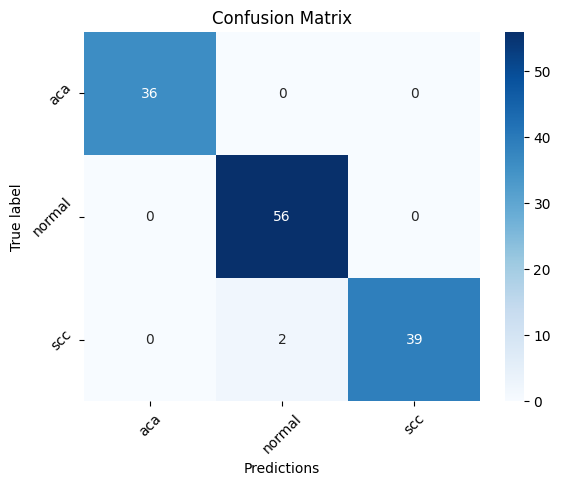

In [20]:
test_classes = ['aca', 'normal', 'scc']
# 计算评价指标

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

# 打印评价指标
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# 计算混淆矩阵
conf_mat = confusion_matrix(all_labels, all_preds)

# 可视化混淆矩阵
sns.heatmap(conf_mat, fmt='g', annot=True, cmap='Blues', xticklabels=test_classes, yticklabels=test_classes)
plt.xlabel('Predictions')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # 旋转x轴标签以便更容易阅读
plt.yticks(rotation=45)  # 旋转y轴标签以便更容易阅读
plt.show()